<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Natural Language Processing From Scratch</h1>
        <h2>Topic Modeling</h2>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import string
from collections import Counter
from pprint import pprint
import gzip
import matplotlib.pyplot as plt 
import numpy as np
from numpy.linalg import svd
from numpy import diag

%matplotlib inline

Set the default style

In [2]:
plt.style.use('./d4sci.mplstyle')

# Preprocessing

Load a standard list of stopwords from a file

In [3]:
stopwords = set([word.lower().strip() for word in open("data/nltk_stopwords.txt", "rt").readlines()])

Define a function to extract the words from our input file. Here we have to be (slightly) more careful than in the previous lesson since we want to keep #tags and @mentions and remove stopwords.

In [4]:
def extract_words(text, stopwords):
    temp = text.split() # Split the text on whitespace
    text_words = []

    punctuation = set(string.punctuation)
    
    #Keep #tags and @mentions
    punctuation.remove("#")
    punctuation.remove("@")
    
    for word in temp:
        # Remove any punctuation characters present in the beginning of the word
        while len(word) > 0 and word[0] in punctuation:
            word = word[1:]

        # Remove any punctuation characters present in the end of the word
        while len(word) > 0 and word[-1] in punctuation:
            word = word[:-1]

        # Simple rule to eliminate (most) URLs
        if len(word) > 0 and "/" not in word:
            # If it's not a stopword
            if word.lower() not in stopwords:
                # Append this word into our list of words.
                text_words.append(word.lower())
        
    return text_words

Process the data from the file. File was obtained from crowdflower (https://www.crowdflower.com/data-for-everyone/) and contains a list of tweets about Apple from 2014 and some information about their sentiment. For our purposes, we only care about the text of each tweet that is located in the last column of the csv file.

We treat each tweet as an individual document, and limit ourselves to only the first 200 tweets.

In [5]:
tweets = []
line_count = 0

for line in open("data/Apple-Twitter-Sentiment-DFE.csv", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header
    if line_count == 1:
        continue
    
    text = ",".join(fields[11:])
    
    if len(text) == 0:
        continue
    
    words = extract_words(text, stopwords)
    
    if len(words) > 0:
        tweets.append(words)
        
    if len(tweets) == 200:
        break

Define the function to calculate the Inverse Document Frequency for each word and the TFIDF matrix. These functions were introduced in the previous lesson.

In [6]:
def inv_doc_freq(corpus_words):
    number_docs = len(corpus_words)
    
    document_count = {}

    for document in corpus_words:
        word_set = set(document)

        for word in word_set:
            document_count[word] = document_count.get(word, 0) + 1
    
    IDF = {}
    
    for word in document_count:
        IDF[word] = np.log(number_docs/document_count[word])
        
    
    return IDF

def tf_idf(corpus_words):
    IDF = inv_doc_freq(corpus_words)
    
    TFIDF = []
    
    for document in corpus_words:
        TFIDF.append(Counter(document))
    
    for document in TFIDF:
        for word in document:
            document[word] = document[word]*IDF[word]
            
    return TFIDF

Get the TFIDF matrix for our corpus of tweets. We should note that while we call it a matrix, this is effectively a list of dictionaries, which we can consider to be a sparse representation of a matrix.

In [7]:
TFIDF = tf_idf(tweets)

In [8]:
TFIDF[:3]

[Counter({'#applesnob': 5.298317366548036,
          '@apple': 0.2169130015635736,
          'cat': 5.298317366548036,
          'chews': 5.298317366548036,
          'cords': 5.298317366548036}),
 Counter({'#aapl': 1.9310215365615626,
          'expects': 5.298317366548036,
          'inquisition': 5.298317366548036,
          'nobody': 5.298317366548036,
          'spanish': 5.298317366548036}),
 Counter({'#aapl:5': 5.298317366548036,
          'apple': 2.5902671654458267,
          'buy': 3.506557897319982,
          'december': 4.605170185988092,
          'gains': 5.298317366548036,
          'rocket': 5.298317366548036,
          'stocks': 5.298317366548036})]

For convenience, extract the word_dict and word_list from the TFIDF matrix.

In [9]:
def build_vocabulary(TFIDF):
    words = set()
    
    for document in TFIDF:
        words |= set(document.keys())
    
    word_list = list(words)
    word_dict = dict(zip(word_list, range(len(word_list))))
    
    return word_dict, word_list

In [10]:
word_dict, word_list = build_vocabulary(TFIDF)

In [11]:
vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 927 words in our vocabulary


In [12]:
word_list[:10]

['#spreadsomejoy',
 'furthermore',
 'customer',
 'life',
 'wanna',
 'thankful',
 'wearable',
 'gams',
 'earn',
 'mega']

Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [13]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict)
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [14]:
TDM = term_document_matrix(TFIDF, word_list, word_dict)
print("Our dataset has:\n%u unique words\n%u documents"%(TDM.shape))

Our dataset has:
927 unique words
200 documents


# Explicit Semantic Analysis

In ESA we use the TD matrix of our corpus as a knowledge base that we can use to look up related documents. To demonstrate how this works, let's create a new document:

In [15]:
new_tweet = ['#macbook', 'mini', 'rocket']

This is not an actual sentence since, for clarity, we are not including stopwords.

In the TD formulation, the values in the word (row) vector representa how much each document is "activated" by that specific word. Naturally, documents in which the word does not appear have weight zero. We can use these word vectors to find a vector representation of our new document where each value is our related it is to every other document in our knowledge base. You can think of this as the set of results one might obtain after a query in a search engine!

The **find_related** simply calcuates the vector corresponding to the new "document" and returns a list of the corresponding weights sorted in decreasing order:

In [16]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
    # Now the entries of new_vector tell us which documents are activated by this one.
    # Let's extract the list of documents sorted by activation
    doc_list = sorted(zip(range(TDM.shape[1]), new_vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

In [17]:
related = find_related_docs(new_tweet, TDM)

Let's take a look a the top 5 results:

In [18]:
for tweet, score in related[:5]:
    print(tweet, " ".join(tweets[tweet]))

166 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
167 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
190 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
191 ipad mini first time startup via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unbox
2 #aapl:5 rocket stocks buy december gains apple


With such small documents, the results are easy to interpret. The first two result are due to mentions of **macbook** and **mini**, the third due to the presence of the word **rocket** but the remaining two results don't include any words in common with our original tweet, just words that appear in similar contexts.

In [19]:
def similarity(vec1, vec2):
    sim = np.dot(vec1, vec2)
    norm1 = np.sqrt(np.dot(vec1, vec1))
    norm2 = np.sqrt(np.dot(vec2, vec2))
    
    return sim/(norm1*norm2)

In [20]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
    
    sim = [similarity(new_vector, TDM[i, :]) for i in range(TDM.shape[0])]
    
    sim_words = sorted(zip(range(TDM.shape[0]), sim), key=lambda x:x[1], reverse=True)
    
    return sim_words

In [21]:
similar = find_similar_words(new_tweet, TDM)

In [22]:
for word, score in similar[:5]:
    print(word_list[word], score)

#macbook 0.842346298979266
#startup 0.8273747381258668
@youtube 0.8273747381258668
#hipster 0.8273747381258668
mini 0.8227410508913036


This approach also returns words that are not included in the document but that are used in a similar context, such as #hipster. One might use this extra words (above some finetuned threshold of similarity) to expand our query and retrieve furhter related documents.

# Latent Semantic Analysis

LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices. 

The first step in any LSA analysis is to apply SVD to the Term-Document matrix:

In [23]:
u, sigma, vt = svd(TDM)

The resulting matrices have the expected shapes, except the singular value matrix, **sigma** that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [24]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(927, 927) (200,) (200, 200)


In [25]:
print(m, n)

927 200


We can now reduce the internal dimention of these matrices to, say, 10. 

In [26]:
k = 10

# Convert the vector of singular values into a diagonal matrix
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices.
uk = u[:,:k]
vtk = vt[:k, :]

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise. 

In [27]:
print(uk.shape, Sk.shape, vtk.shape)

(927, 10) (10, 10) (10, 200)


There are no easy ways to determine the number of topics to choose, but a good rule of thumb is to identify kinks in the values of sigma

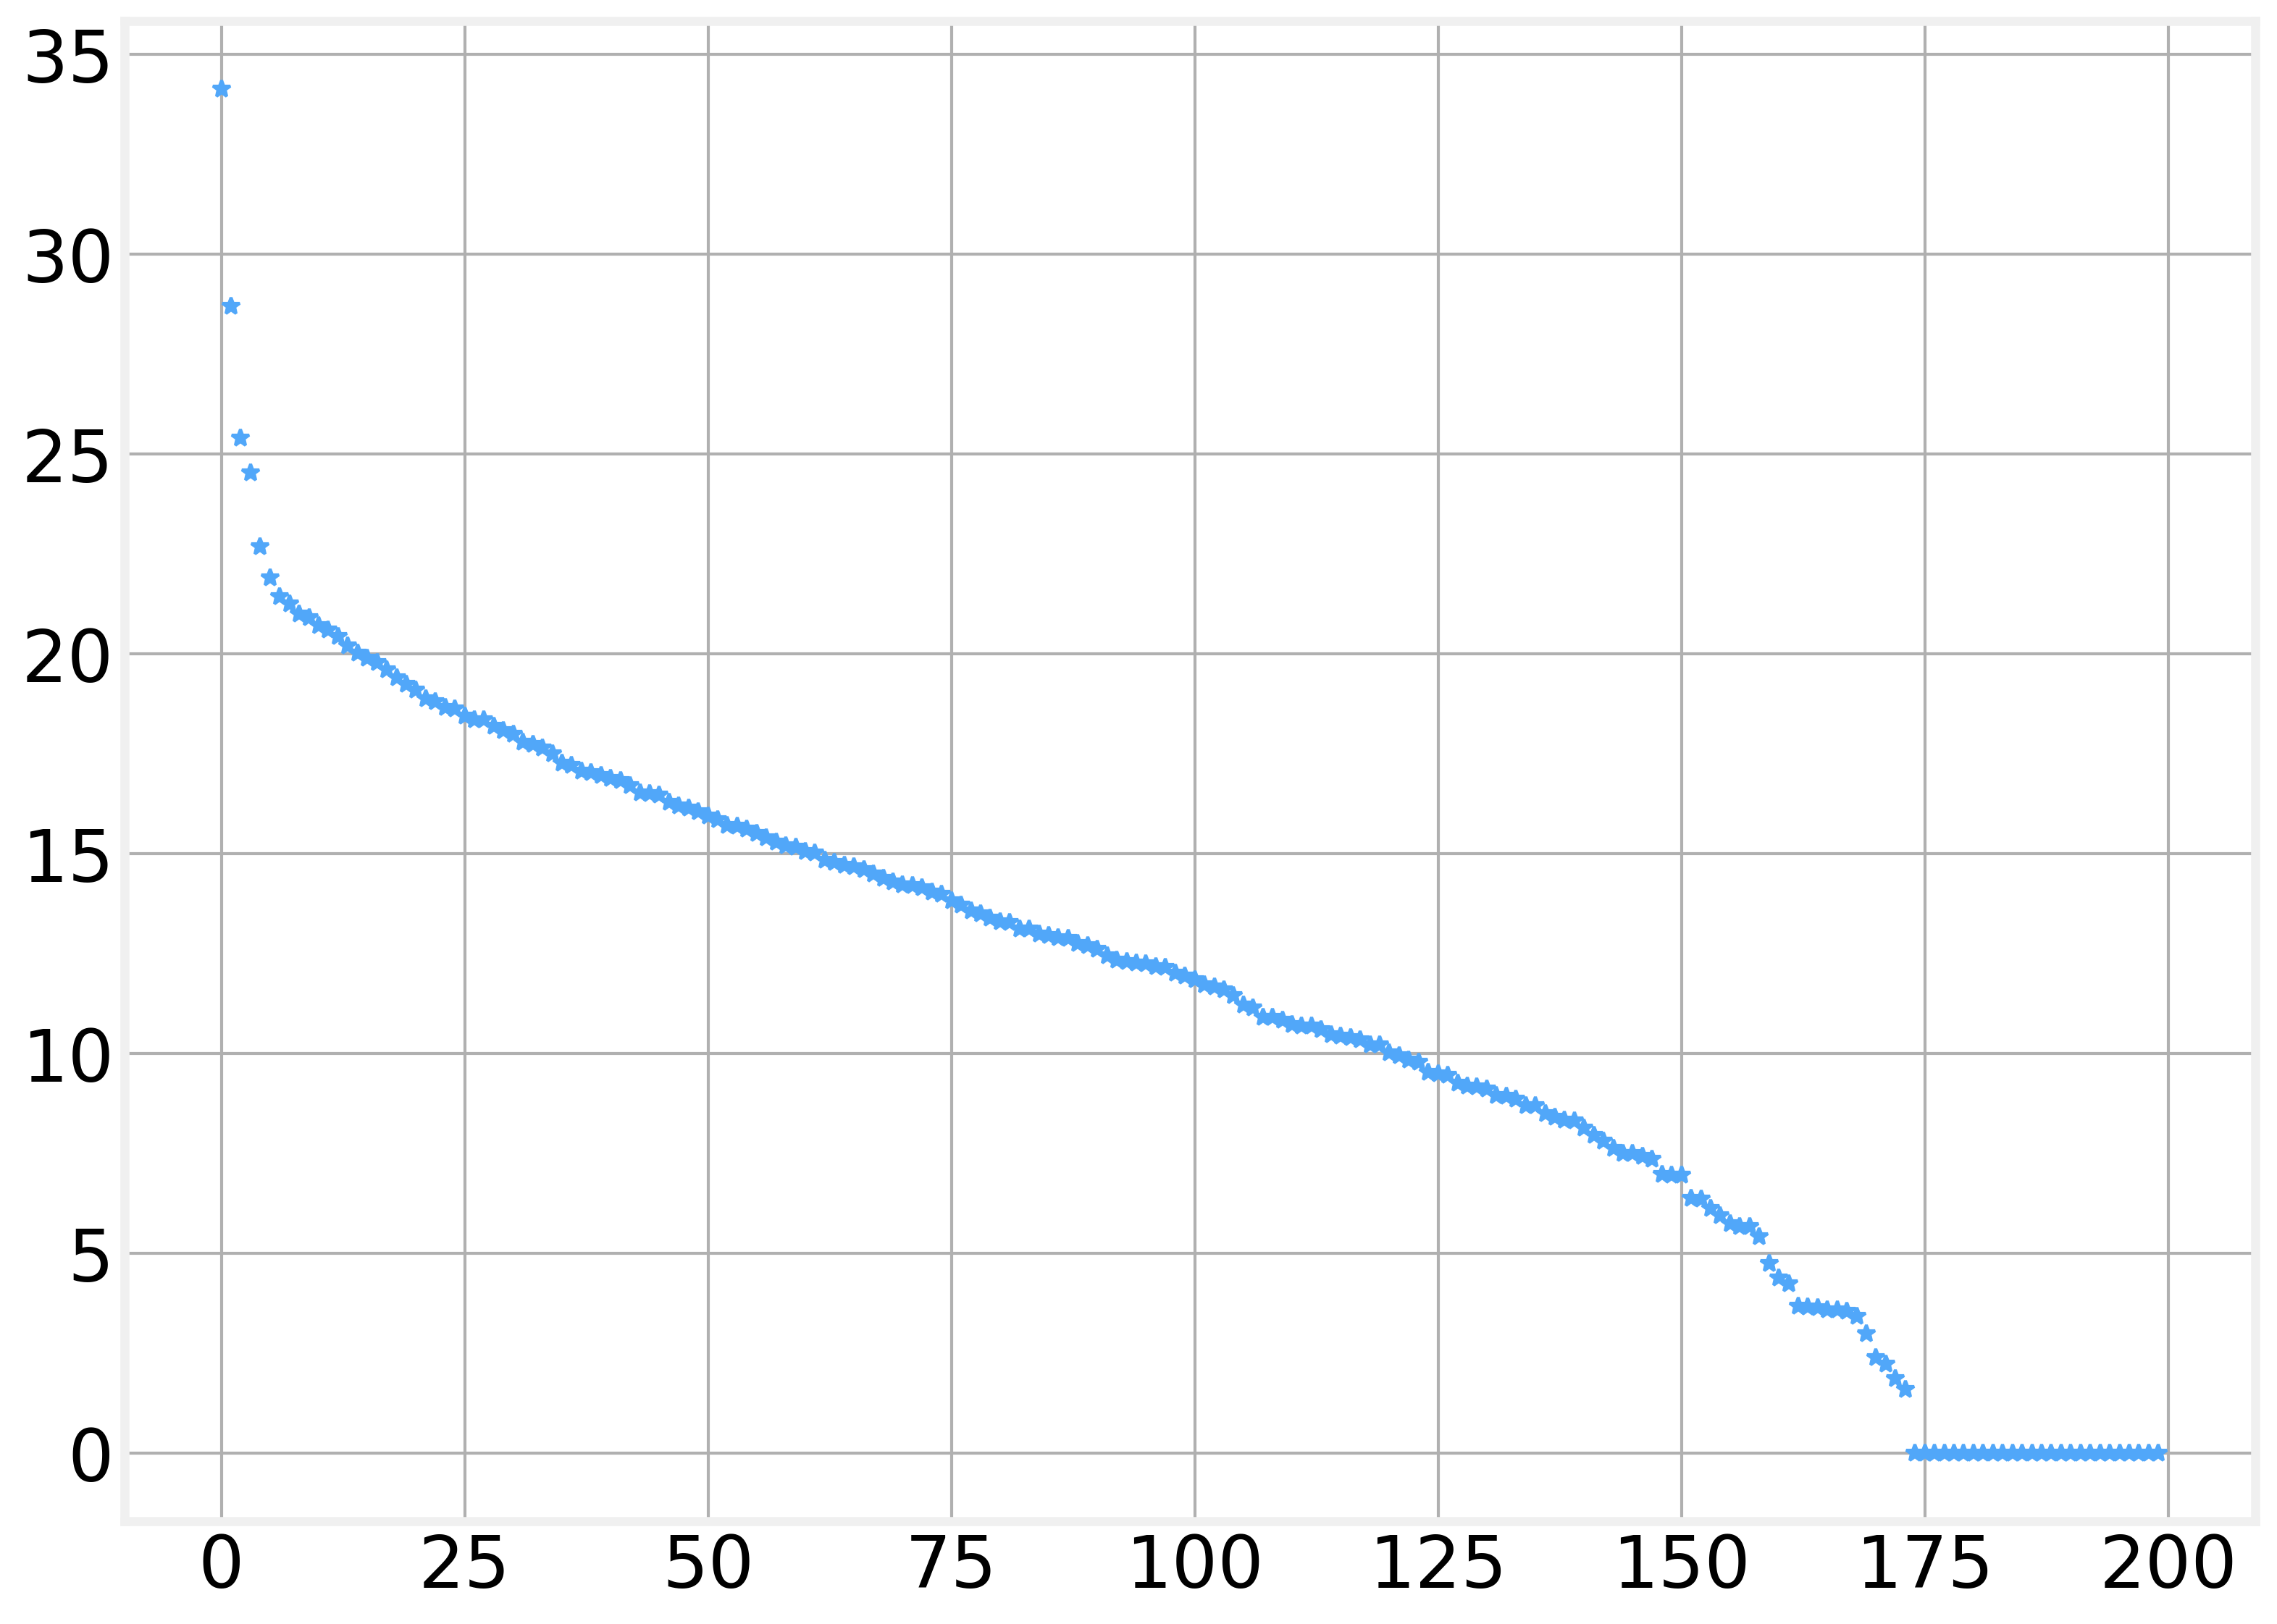

In [28]:
plt.plot(range(200), sigma, '*')
plt.gcf().set_size_inches(11, 8)

We can also explore the way in which the topics are defined by considering the words for which they have stronger weights:

In [29]:
# Sort the list of words by the weight they have in a specific topic
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

For example, for topic 5, we have strong mentions of AIDS day and the Produc (RED) iPhone launch:

In [30]:
topic_words = top_words(uk[:,4], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

day 0.10216338113195889
aids 0.09762171322627652
world 0.08901600463092008
logo 0.07830216141310037
red 0.06212422053900606
dec 0.046103107051189786
abl 0.04610310705118978
launches 0.04610310705118978
campaign 0.04027462680866797
#apple 0.0376535185372932


On the other hand, if we were trying to map a specific sentence or document into the most relevant topic we would simply have to project it into the singular space. First we define the vector in the "regular" word space:

In [31]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

and now we project it into the singular space:

In [32]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([ 1.62243400e-04,  1.44900491e-02, -1.09973213e-03,  4.30257980e-05,
       -9.69106965e-04,  4.54646796e-03, -7.58613138e-04,  2.40772326e-03,
       -3.82599561e-03,  1.95924079e-03])


From where we see that hte most relevant topic is topic number 1:

In [33]:
topic = np.argmax(doc_singular)

topic_words = top_words(uk[:,topic], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

#macbook 0.3072355938213902
#startup 0.3054014569972671
@youtube 0.30540145699726706
#hipster 0.305401456997267
#macbookpro 0.29809606289080276
via 0.29187957210987764
mini 0.20949666233803638
ipad 0.20381766001212548
#ipadmini 0.19891025664321743
startup 0.19327488007614946


In [34]:
topic

1

Which indeed seems relevant.

# Non-Negative Matrix Factorization

The idea behind applying NMF to a Term-Document Matrix is similar to the goals behind using SVD to perform Latent Semantic Analysis. NMF is a general matrix factorization algorithm and, as such, the factor matrices it finds can also be thought of as internal or latent dimensions. 

Similarly to the case of SVD, we can perform a partial reconstruction of the original matrix by reducing the internal dimensions. Naturally, as the number of latent dimensions increases, the reconstruction error decreases since we are removing less and less information:

In [35]:
def NMF(V, k):
    n, m = V.shape

    W = np.random.rand(n, k)
    H = np.random.rand(k, m)

    error = 1
    err = 1

    while err > 1e-3:
        old_error = error

        hn = np.dot(W.T, V)
        hd = np.dot(W.T, np.dot(W, H))

        H = H*hn/hd

        wn = np.dot(V, H.T)
        wd = np.dot(W, np.dot(H, H.T))

        W = W*wn/wd

        error = np.sum(np.power(V-np.dot(W, H), 2.0))
        err = np.abs(old_error-error)

    return W, H, error


Let's see how the error changes with the number of components.

In [36]:
error = []

for comps in range(2, 35+1):
    W, H, err = NMF(TDM, comps)
    print(comps, err)
    error.append(err)

2 32018.606312443604
3 31373.946076187276
4 30865.39986323991
5 30320.282059390756
6 29791.273581264686
7 29374.145252510523
8 28895.24174333893
9 28475.080993488053
10 28055.695325012206
11 27642.265250322962
12 27303.295564270047
13 26777.611349181552
14 26381.18602657818
15 26050.542852179802
16 25657.885094205332
17 25271.98210845201
18 24846.387056197585
19 24527.652058296997
20 24143.079545218305
21 23814.22665479127
22 23588.47267969822
23 23175.99796776421
24 22838.381812486343
25 22436.519746177746
26 22104.091082504074
27 21791.50338258379
28 21401.724230727497
29 21193.345637744867
30 20770.932165890226


/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


31 nan
32 20268.992898000317
33 19892.068491960858
34 19585.205189702676
35 19243.04095392921


The nan values found above are due to numerical instabilities. In practice you should use a well tested numerical library such as sklearn.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

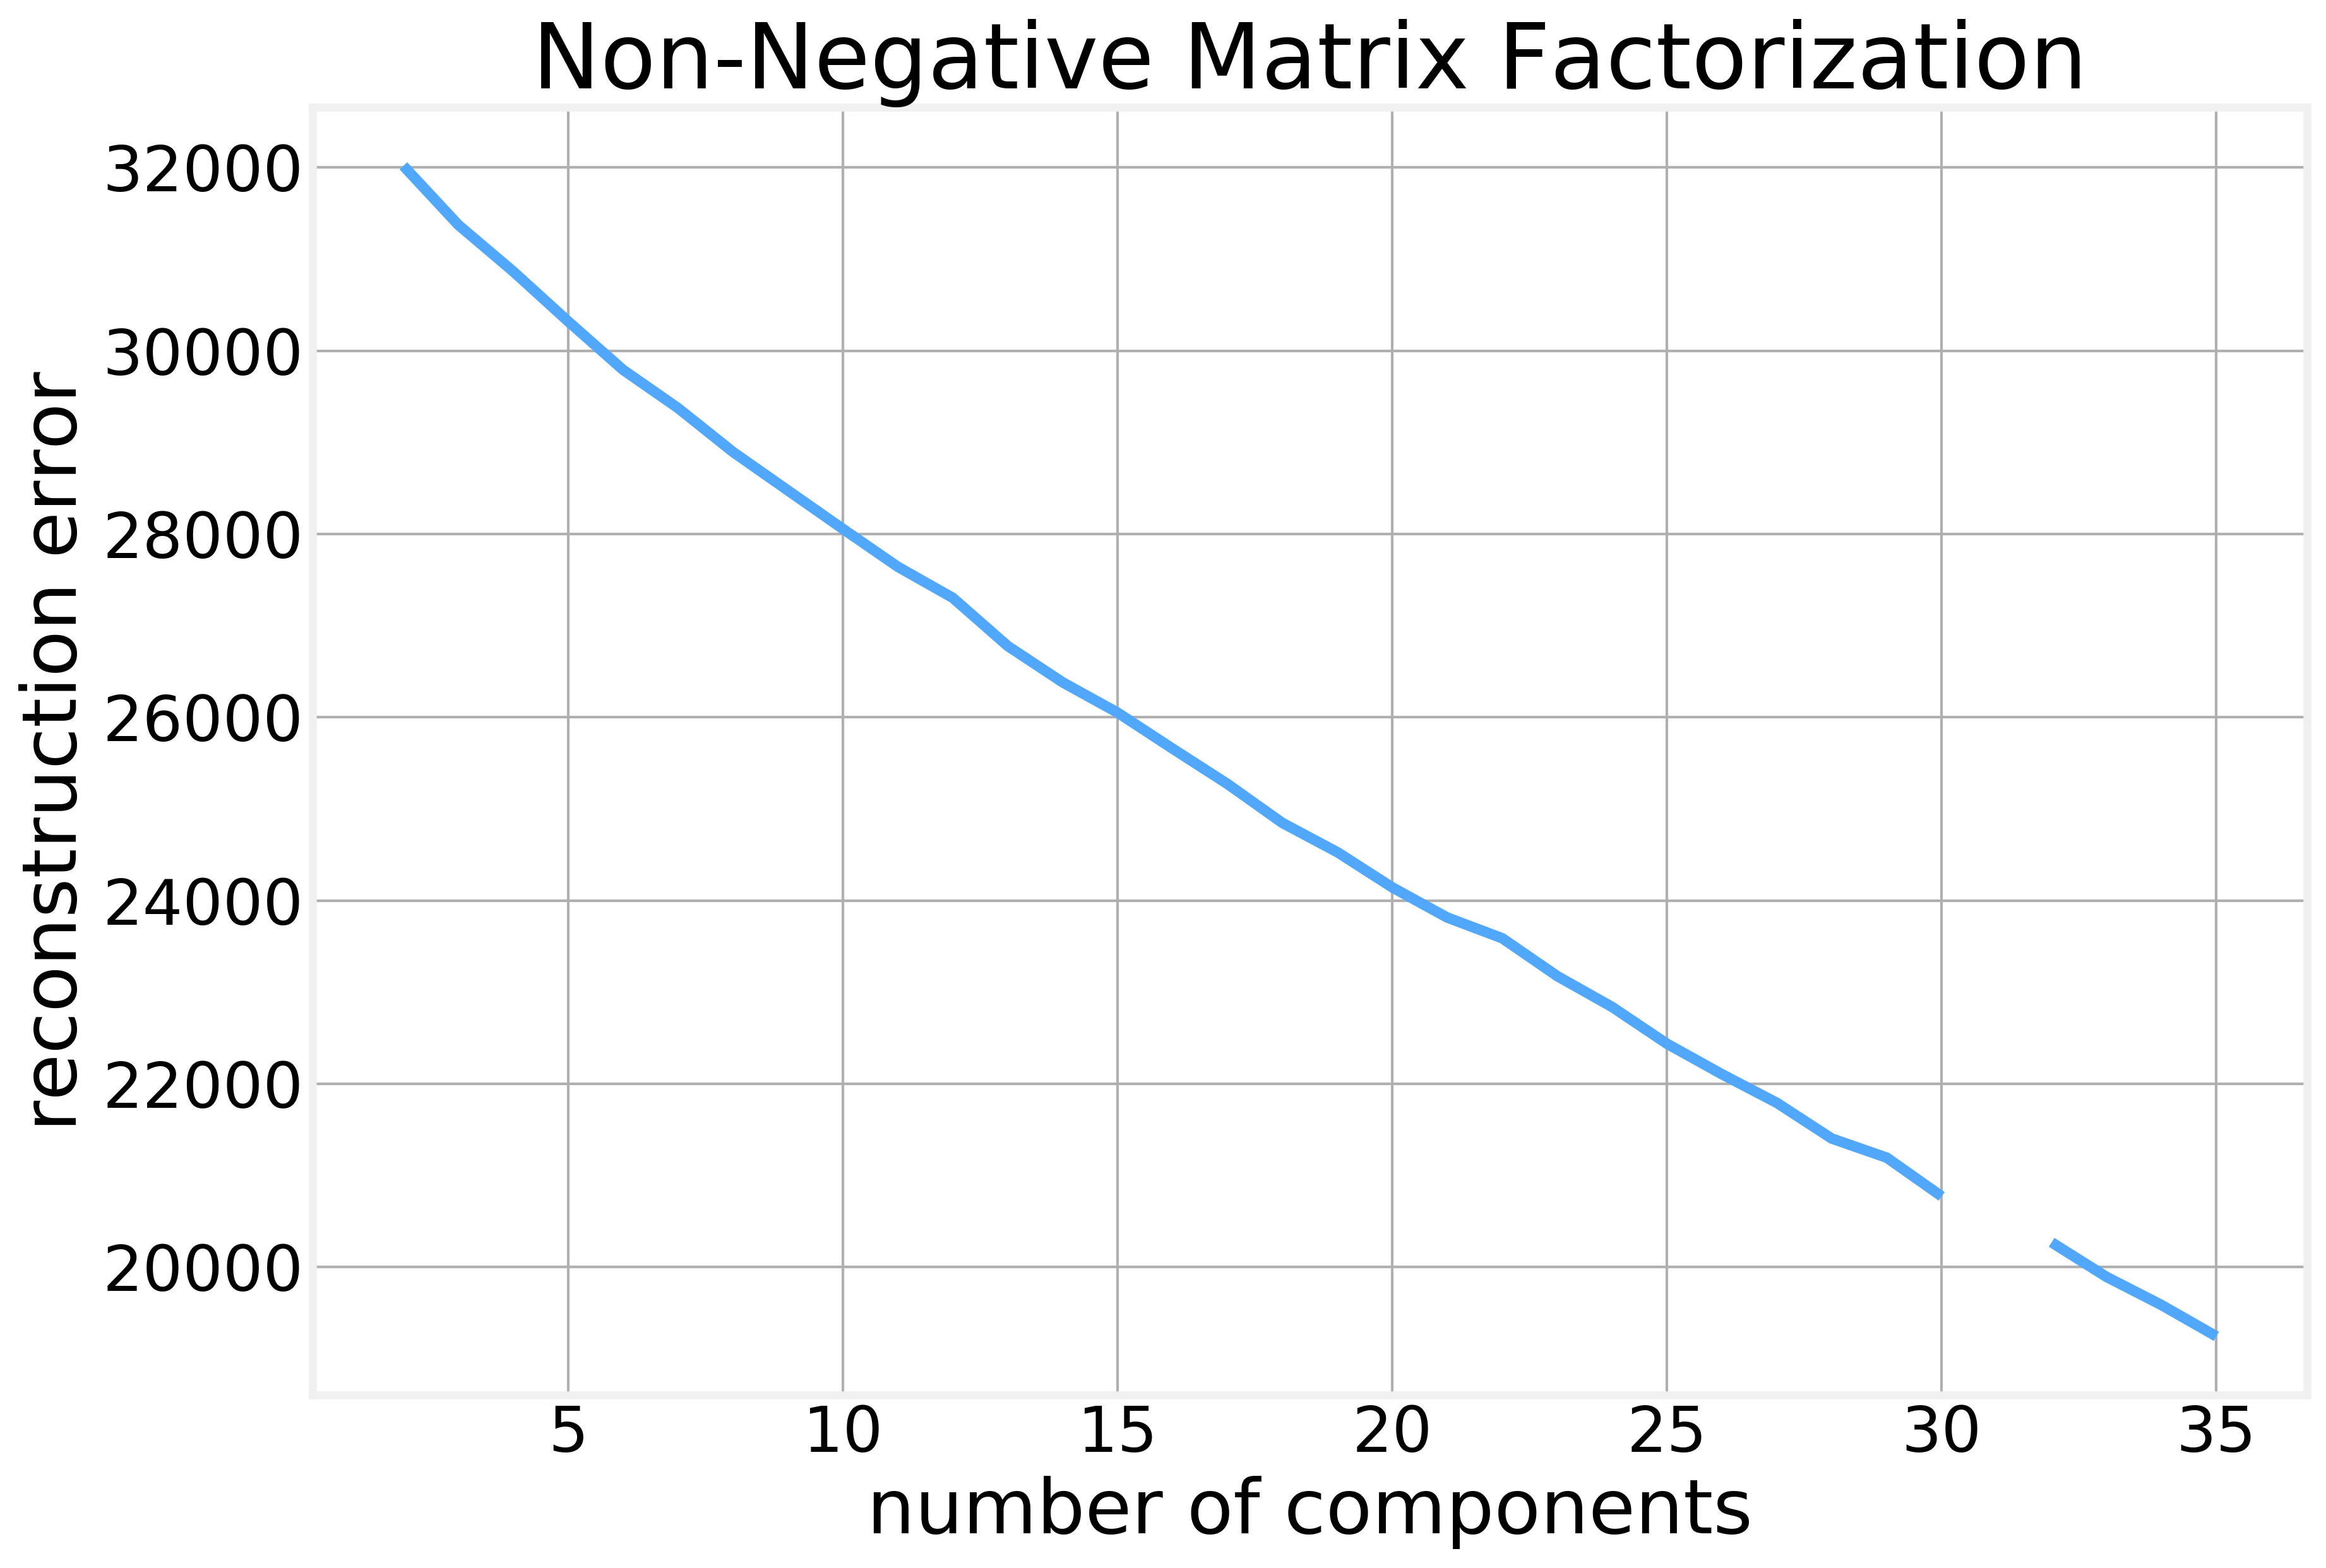

In [37]:
plt.plot(range(2, 35+1), error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

For the remainder of this section, lets fix the number of so that we can use these results to illustrate the power of NMF.

In [38]:
W, H, err = NMF(TDM, 10)

When we apply NMF to a Term-Document matrix, as defined above, the resulting factors prove useful for topic detection. In particular, the W matrix provides us with the definition of each topic as a weighted distribution over all the words in the corpus:

Let's look at a couple of examples:

In [39]:
topic_words = top_words(W[:,2], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

store 16.28799054174023
#winterseve 16.21678874237422
band 16.21678874237422
@donacamp 16.21678874237422
brass 16.21678874237422
broadway 16.21678874237422
#nyc 16.21678874237422
rt 10.916638380275405
steve 10.912667331776445
jobs 10.912667331776445


In [40]:
topic_words = top_words(W[:,5], word_list)
for word, weight in topic_words[:10]:
    print(word, weight)

day 23.41916176266057
aids 22.982074202467235
world 21.84993789798991
red 20.93080868063914
logo 18.494555190683474
#apple 14.17748300928332
#aapl 10.935785027920778
apple 10.525687961565819
dec 10.261199236937786
abl 10.261199236937786


<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>